In [107]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time

from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
from sklearn.neighbors import KernelDensity
import statsmodels.api as sma

from scipy.integrate import quad
from scipy.interpolate import interp1d

from SyntheticDataModule import *
from IHDPDataModule import *
from estimators import *
from utils import *
from mmr_utils import *

In [108]:
COL_NAME_DICT = dict(zip(["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10"],["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10"]))

RCT size: 500, OS size: 1000, time elapsed: 16.42


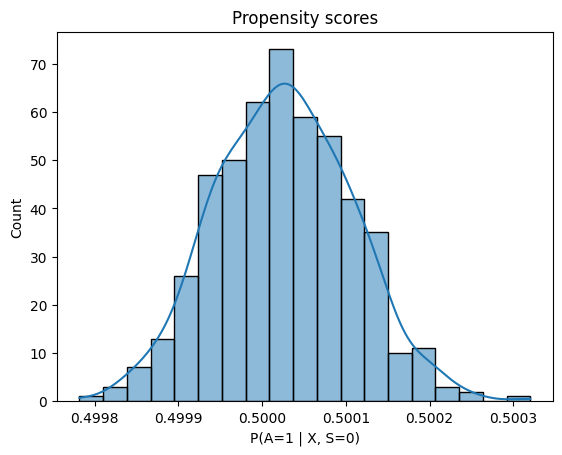

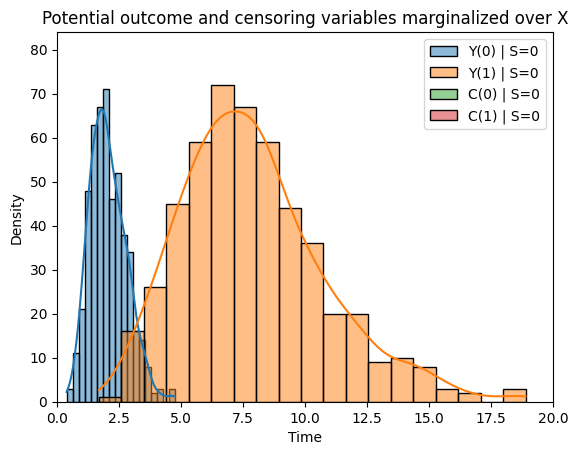

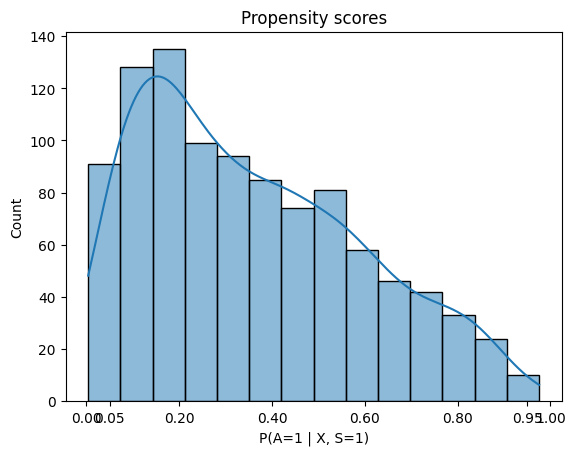

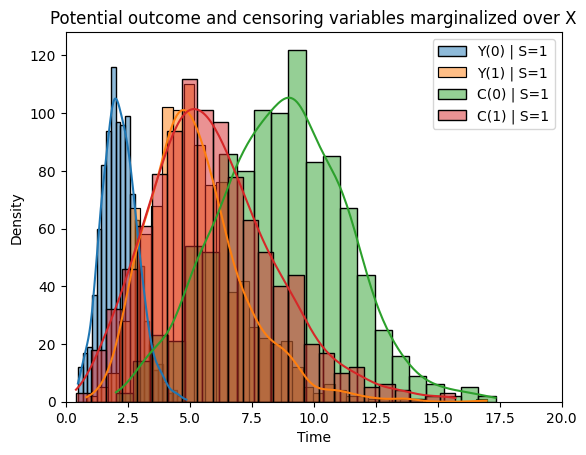

In [109]:
mmr_keys = ["CDR", "IPW-Drop"]
CD = 10
UC = 0
jD = read_json('conditional-IC/diffPO-3beta.json', CD, UC, mmr_keys)

m = 2
os_size = int(jD['rct_size'] * m)

t1 = time()

df_combined, df_comb_drop, RCTData, OSData = generate_data(CD, os_size, jD)
Fb_Y, Gb_C = est_nuisance(df_combined, df_comb_drop, jD)

print('RCT size: {}, OS size: {}, time elapsed: {:.2f}'.format(jD['rct_size'], os_size, time() - t1))

summary_df = pd.concat([RCTData.summary(plot=True), OSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

crop_prop = True

In [110]:
mmr_stats = np.zeros((len(mmr_keys), 2))  # store results and p-val for each mmr test

for kind, key in enumerate(mmr_keys):
    if 'Drop' in key:
        df_mmr = df_comb_drop.copy()
    else:
        df_mmr = df_combined.copy()

    if jD['crop_prop'] and ('Drop' not in key):
        df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95) &\
                (1e-4 < df_mmr['Gb(T|X,S,A)'])].copy().reset_index(drop=True)

    if jD['crop_prop'] and ('Drop' in key):
        df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95)].copy().reset_index(drop=True)

    signal0, signal1 = jD['test_signals'][key][0], jD['test_signals'][key][1]
    mmr_stats[kind, 0], mmr_stats[kind, 1] = mmr_test(df_mmr, jD['cov_list'], jD['B'], laplacian_kernel, signal0, signal1)

In [111]:
def calc_wit_fn(df, kernel, x_arr, signal0, signal1, weight_marg=True):
    kxx = kernel(x_arr, df[COL_NAME_DICT.keys()].values)
    #kxx = kernel(x_arr.reshape(-1,1), np.array(df[x_name]).reshape(-1,1))
    psi = (df[signal1] - df[signal0]).values[None,:]
    
    #if weight_marg:
    #    data = np.array(df[x_name])
    #    dens = sma.nonparametric.KDEUnivariate(data)
    #    dens.fit()
    #    #pdb.set_trace()
    #    return (kxx @ psi) / (len(psi) * np.clip(dens.evaluate(x_arr), a_max=1000, a_min=0.5)) , kxx, psi
    # else:
    if weight_marg:
        norm = np.mean(kxx, axis=1)
    else:
        norm = 1
    return np.mean(kxx * psi,axis=1) / norm, kxx, psi, norm

In [112]:
calc_wit_fn(df_combined,laplacian_kernel,df_combined[COL_NAME_DICT.keys()].values,"S0_cdr_Miss_None_est_CATE","S1_cdr_Miss_None_est_CATE")[0].shape

(1500,)

In [113]:
witness_fun = calc_wit_fn(df_combined,laplacian_kernel,df_combined[COL_NAME_DICT.keys()].values,"S0_cdr_Miss_None_est_CATE","S1_cdr_Miss_None_est_CATE")[0]

In [114]:
col = "X9"

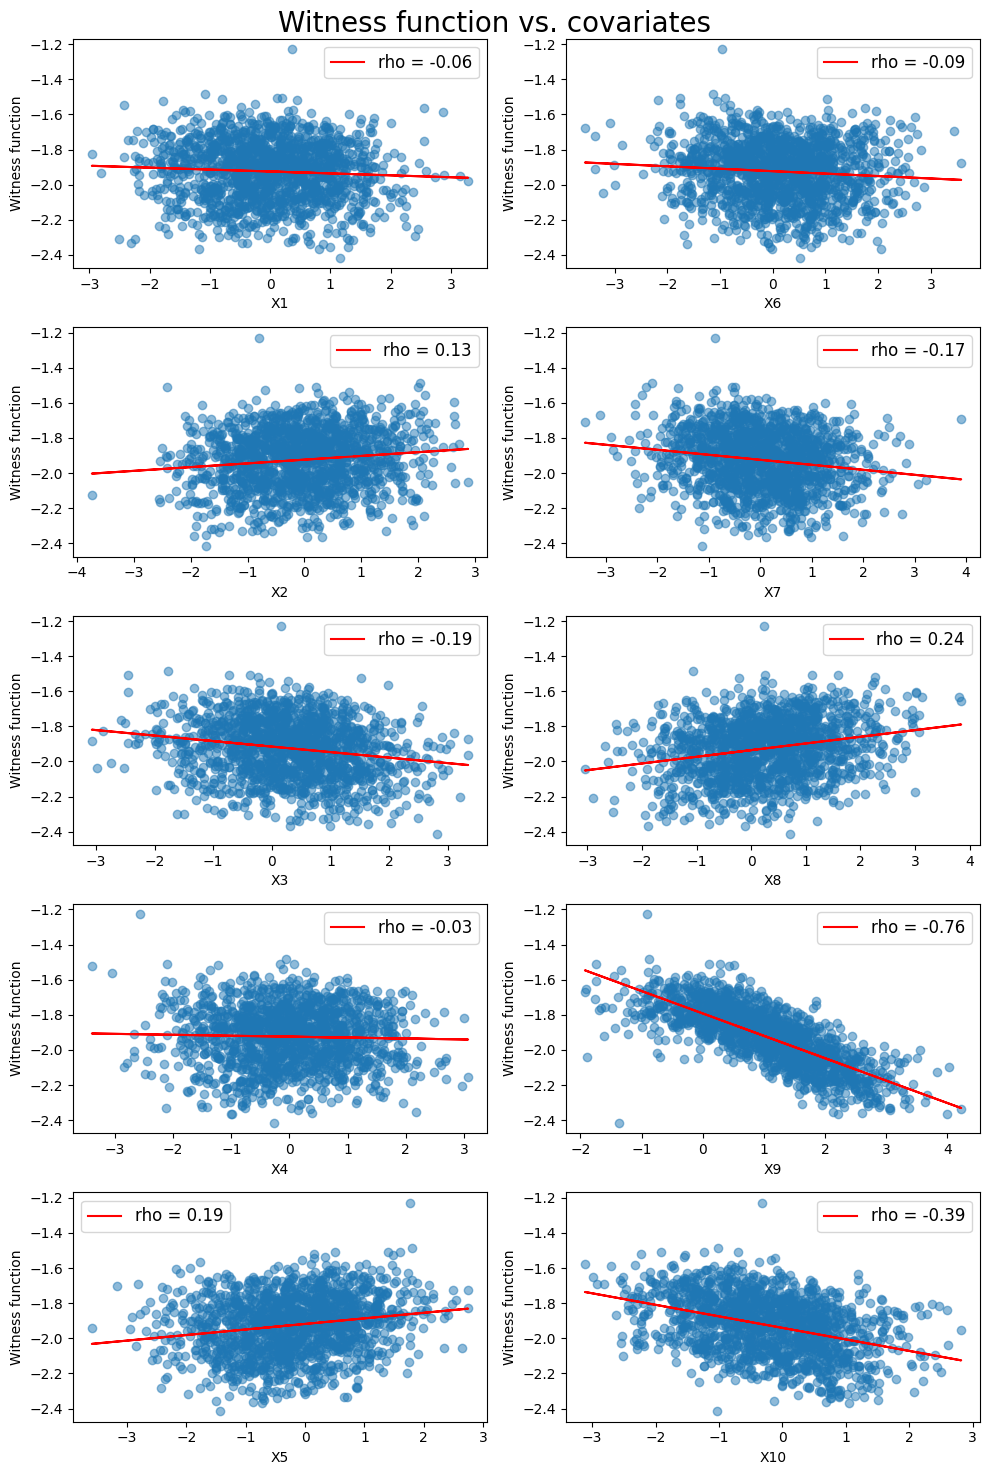

In [150]:
witness_fun = calc_wit_fn(df_combined,laplacian_kernel,df_combined[COL_NAME_DICT.keys()].values,"S0_cdr_Miss_None_est_CATE","S1_cdr_Miss_None_est_CATE", weight_marg=True)[0]

fig, axs = plt.subplots(figsize = (10,15), nrows = 5, ncols = 2)

for i, col in enumerate(list(COL_NAME_DICT.keys())[1:]):
    ax = axs[i%5, i//5]
    ax.scatter(df_combined[col], witness_fun, alpha = 0.5)
    m, b = np.polyfit(df_combined[col], witness_fun, 1)
    corr = np.corrcoef(df_combined[col].values, witness_fun)[0,1]
    ax.plot(df_combined[col], m*df_combined[col] + b, color='red', label = f"rho = {corr:.2f}")
    ax.set_xlabel(f"{COL_NAME_DICT[col]}")
    ax.set_ylabel("Witness function")
    ax.legend(fontsize = 12)

plt.suptitle("Witness function vs. covariates", fontsize = 20)
plt.tight_layout()

In [ ]:
np.random.randn(10,10)

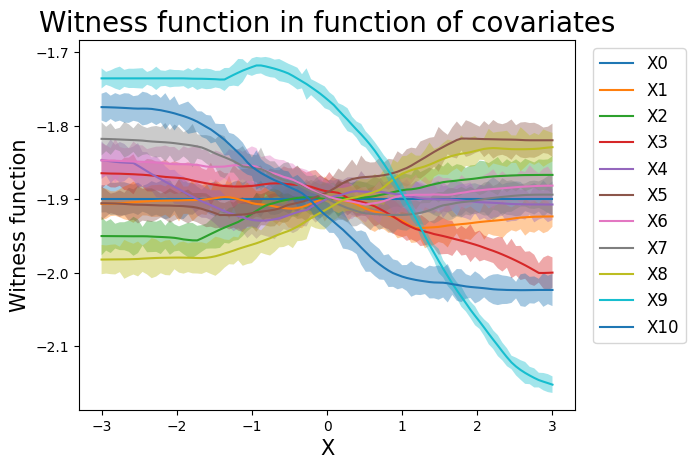

In [176]:
repeats = 20
for i, col in enumerate(COL_NAME_DICT.keys()):
    means = (df_combined[COL_NAME_DICT.keys()].mean().values)[None].repeat(100,axis=0)
    means[:,i] = np.linspace(-3,3,100)
    witness_fun = calc_wit_fn(df_combined,laplacian_kernel,means,"S0_cdr_Miss_None_est_CATE","S1_cdr_Miss_None_est_CATE", weight_marg=True)[0]
    plt.plot(np.linspace(-3,3,100),witness_fun, label = f"{COL_NAME_DICT[col]}")

    stds_list = []
    for _ in range(repeats):
        stds = (df_combined[COL_NAME_DICT.keys()].mean().values)[None].repeat(100,axis=0) 
        stds += 0.1 * np.random.randn(*stds.shape)
        stds[:,i] = np.linspace(-3,3,100)
        witness_fun_std = calc_wit_fn(df_combined,laplacian_kernel,stds,"S0_cdr_Miss_None_est_CATE","S1_cdr_Miss_None_est_CATE", weight_marg=True)[0]
        stds_list.append(witness_fun_std)
    witness_fun_std = np.stack(stds_list).std(axis=0)

    plt.fill_between(np.linspace(-3,3,100),witness_fun-witness_fun_std, witness_fun+witness_fun_std, alpha = 0.4)

    plt.legend(fontsize=12, loc="upper right", bbox_to_anchor=(1.24,1))
    plt.xlabel("X", fontsize = 15)
    plt.ylabel("Witness function", fontsize = 15)
    plt.title("Witness function in function of covariates", fontsize = 20)

In [ ]:
witness_fun_std